In [1]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
training = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/training_new.csv")
validation = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/validation_new.csv")
print(len(training),len(validation))

1102605 127440


In [4]:
# 훈련 데이터와 테스트 데이터 합치기 ==> 추후 분리할 예정
training = pd.concat([training,validation])
len(training)

1230045

## 훈련 데이터 만들기

In [5]:
training.sample(10)

,Unnamed: 0,standard,dialect
611401,611401,옆에서 도와주는 사람들이 있었 있었어요 야,옆에서 도와주는 사람들이 이성 이서서 야
1066756,1066756,어쩔 수가 없어 나도 제주도 살고 싶은데,어쩔 수가 어서 나도 제주도 살고 싶은디
31384,31384,걸어서 양 저 시험 보러 왔다 간 것이 생각납니다,걸언 양 저 시험 보러 왔당 간 것이 생각납니다
831343,831343,거기 뭐있니,거기 뭐이시
1085996,1085996,그렇게 해도 비행기 값만 해도 거의 한 한 삼사백 정도 나오니까,겅 해도 비행기 값만 해도 거의 한 한 삼사백 정도 나오니까
449454,449454,말했다고 하면서 하니까,고랐댄 허멍 허난
943125,943125,있는지 모르고 눌러버린거 아니,있는지 모르고 눌러분거 아니
303767,303767,길에 그냥 막 이중으로 이렇게 이쪽길 이쪽길 세워버리면,길에 그냥 막 이중으로 영 이쪽길 이쪽길 세와불면
353474,353474,그냥 금방 난 질리는 거야,그냥 금방 난 질리는 거
689104,689104,이 얼굴 좀 작고 목 긴 애들이 입어야 예뻐요,이 얼굴 좀 작고 목 긴 애들이 입어야 예뻐마씨


In [6]:
# 10만개만 시범적으로
standard_input = training.standard[:100000]
dialect_input = training.dialect[:100000].apply(lambda x: "<sos>" + " "+ str(x))
dialect_output = training.dialect[:100000].apply(lambda x: str(x) + " "+ "<eos>" )

In [7]:
src_input = []
for sentence in tqdm(standard_input):
  result = []
  for word in str(sentence).split():
    result.append(word)
  src_input.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 232361.76it/s]


In [8]:
print(src_input[5:10])

[['아그러니까', '뉴스에도', '많이', '나오잖아', '뭐막', '짤리고', '막', '이렇게', '이렇게', '한다고', '그러니까'], ['그러니까', '제주도는', '워낙', '또', '돌멩이가', '많아서'], ['그러니까'], ['그러니깐'], ['아', '쫓아갈때', '아우', '뱀나올까봐']]


In [9]:
tar_input = []
for sentence in tqdm(dialect_input):
  result = []
  for word in str(sentence).split():
    result.append(word)
  tar_input.append(result)


100%|██████████| 100000/100000 [00:00<00:00, 198827.32it/s]


In [10]:
print(tar_input[5:10])

[['<sos>', '아그러니까', '뉴스에도', '많이', '나오잖아', '뭐막', '짤리고', '막', '영', '이추룩', '한다고', '거난'], ['<sos>', '거난', '제주도는', '워낙', '또', '돌멩이가', '많아그네'], ['<sos>', '겅하니까'], ['<sos>', '겅하니깐'], ['<sos>', '아', '쫓아갈때', '아우', '뱀나올카부덴이']]


In [11]:
tar_output = []
for sentence in tqdm(dialect_output):
  result = []
  for word in str(sentence).split():
    result.append(word)
  tar_output.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 173736.39it/s]


In [12]:
print(tar_output[5:10])

[['아그러니까', '뉴스에도', '많이', '나오잖아', '뭐막', '짤리고', '막', '영', '이추룩', '한다고', '거난', '<eos>'], ['거난', '제주도는', '워낙', '또', '돌멩이가', '많아그네', '<eos>'], ['겅하니까', '<eos>'], ['겅하니깐', '<eos>'], ['아', '쫓아갈때', '아우', '뱀나올카부덴이', '<eos>']]


In [13]:
tokenizer_src = Tokenizer()
tokenizer_src.fit_on_texts(src_input)
encoder_input = tokenizer_src.texts_to_sequences(src_input)

tokenizer_tar = Tokenizer()
tokenizer_tar.fit_on_texts(tar_input)
decoder_input = tokenizer_tar.texts_to_sequences(tar_input)

tokenizer_tar.fit_on_texts(tar_output)
decoder_output = tokenizer_tar.texts_to_sequences(tar_output)

문장 최대 길이: 88
문장 평균 길이: 6.5345


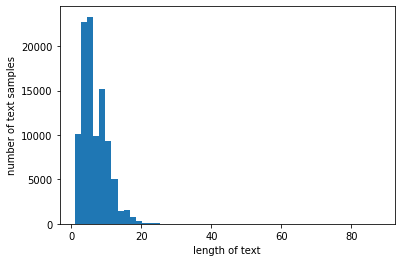

In [14]:
print("문장 최대 길이:", max(len(text) for text in encoder_input))
print("문장 평균 길이:", sum(map(len,encoder_input))/len(encoder_input))
plt.hist([len(text) for text in encoder_input],bins = 50)
plt.xlabel("length of text")
plt.ylabel("number of text samples")
plt.show()

In [15]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for text in nested_list:
    if len(text) <= max_len:
      count += 1
  print("전체 샘플의 길이가 {} 이하인 샘플의 비율: {}".format(max_len, (count / len(nested_list))*100))

In [16]:
max_len = 25
below_threshold_len(max_len, encoder_input)
below_threshold_len(max_len, decoder_input)
below_threshold_len(max_len, decoder_output)

전체 샘플의 길이가 25 이하인 샘플의 비율: 99.926
전체 샘플의 길이가 25 이하인 샘플의 비율: 99.907
전체 샘플의 길이가 25 이하인 샘플의 비율: 99.907


In [17]:
encoder_input = pad_sequences(encoder_input,padding="post",maxlen = max_len)
decoder_input = pad_sequences(decoder_input, padding = "post", maxlen = max_len)
decoder_target = pad_sequences(decoder_output,padding="post", maxlen = max_len)

In [18]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (100000, 25)
디코더의 입력의 크기(shape) : (100000, 25)
디코더의 레이블의 크기(shape) : (100000, 25)


In [19]:
src_vocab_size = len(tokenizer_src.word_index) + 1
tar_vocab_size = len(tokenizer_tar.word_index) + 1
print("표준어 단어 집합의 크기 : {:d}, 제주방언 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

표준어 단어 집합의 크기 : 104922, 제주방언 단어 집합의 크기 : 128838


In [20]:
# 단어->정수 & 정수->단어 딕셔너리
src_to_index = tokenizer_src.word_index
index_to_src = tokenizer_src.index_word
tar_to_index = tokenizer_tar.word_index
index_to_tar = tokenizer_tar.index_word

In [21]:
# 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [34767 75207 33835 ... 27448  6149 50464]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

## 훈련데이터와 테스트 데이터 분리

In [23]:

encoder_input_train = encoder_input[:80000]
decoder_input_train = decoder_input[:80000]
decoder_target_train = decoder_target[:80000]

encoder_input_test = encoder_input[80000:]
decoder_input_test = decoder_input[80000:]
decoder_target_test = decoder_target[80000:]

In [24]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (80000, 25)
훈련 target 데이터의 크기 : (80000, 25)
훈련 target 레이블의 크기 : (80000, 25)
테스트 source 데이터의 크기 : (20000, 25)
테스트 target 데이터의 크기 : (20000, 25)
테스트 target 레이블의 크기 : (20000, 25)


## 모델 설계하기

In [25]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [26]:
embedding_dim = 64
hidden_units = 64

In [27]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [28]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta = 0, patience = 5, mode = "auto")
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=200, epochs=70,callbacks=[early_stopping])

Epoch 1/70
400/400 [==============================] - 681s 2s/step - loss: 3.9477 - acc: 0.7073 - val_loss: 2.5412 - val_acc: 0.7401
Epoch 2/70
400/400 [==============================] - 681s 2s/step - loss: 2.4624 - acc: 0.7411 - val_loss: 2.5170 - val_acc: 0.7414
Epoch 3/70
400/400 [==============================] - 688s 2s/step - loss: 2.3898 - acc: 0.7432 - val_loss: 2.4416 - val_acc: 0.7440
Epoch 4/70
187/400 [=============>................] - ETA: 5:13 - loss: 2.2986 - acc: 0.7460

In [ ]:
# 모델 저장하기
from keras.models import load_model
model.save("jeju_model_100k.h5")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')
